# Experiment: K-Means Clustering

Task: **clustering**

In [1]:
from __future__ import annotations

import sys
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

SEED = 42
np.random.seed(SEED)

REPO_ROOT = Path.cwd().resolve().parents[0]  # notebooks/ -> repo root
sys.path.insert(0, str(REPO_ROOT))

PREPROCESSED_ROOT = REPO_ROOT / 'data' / '02-preprocessed'
BASELINE_CONFIG_JSON = REPO_ROOT / 'config' / 'baseline_feature_config.json'

prepared_dirs = sorted([p for p in PREPROCESSED_ROOT.iterdir() if p.is_dir()], key=lambda p: p.name)
if not prepared_dirs:
    raise FileNotFoundError(f'No prepared datasets found under: {PREPROCESSED_ROOT}')
DATASET_DIR = prepared_dirs[-1]

cleaned_parquet = DATASET_DIR / 'cleaned.parquet'
cleaned_csv = DATASET_DIR / 'cleaned.csv'
split_csv = DATASET_DIR / 'split.csv'

print(f'Using prepared dataset: {DATASET_DIR}')
print(f'Using baseline config:  {BASELINE_CONFIG_JSON}')

if cleaned_parquet.exists():
    df = pd.read_parquet(cleaned_parquet)
elif cleaned_csv.exists():
    df = pd.read_csv(cleaned_csv)
else:
    raise FileNotFoundError('Expected cleaned.parquet or cleaned.csv')

splits = pd.read_csv(split_csv)

from src.pipelines.features import apply_baseline_feature_config, load_baseline_feature_config
cfg = load_baseline_feature_config(BASELINE_CONFIG_JSON)

required_cols = {cfg.row_id_col, cfg.target_col}
missing_required = required_cols - set(df.columns)
if missing_required:
    raise KeyError(f'Missing required columns in cleaned data: {sorted(missing_required)}')

X_full = apply_baseline_feature_config(df, cfg)
y_full = df[cfg.target_col].astype(str)

df_split = df[[cfg.row_id_col]].merge(splits[[cfg.row_id_col, 'split']], on=cfg.row_id_col, how='left')
if df_split['split'].isna().any():
    raise ValueError('Some rows are missing split assignments (split.csv join failed)')

mask_train = df_split['split'].eq('train')
mask_val = df_split['split'].eq('val')
mask_test = df_split['split'].eq('test')

X_train, y_train = X_full.loc[mask_train].reset_index(drop=True), y_full.loc[mask_train].reset_index(drop=True)
X_val, y_val = X_full.loc[mask_val].reset_index(drop=True), y_full.loc[mask_val].reset_index(drop=True)
X_test, y_test = X_full.loc[mask_test].reset_index(drop=True), y_full.loc[mask_test].reset_index(drop=True)

print('Split sizes:', X_train.shape, X_val.shape, X_test.shape)


Using prepared dataset: C:\repos\ml-cybersecurity_attacks\data\02-preprocessed\cybersecurity_attacks_v1_2025-12-29
Using baseline config:  C:\repos\ml-cybersecurity_attacks\config\baseline_feature_config.json
Split sizes: (28000, 25) (6000, 25) (6000, 25)


In [2]:
# Build preprocessing: impute + one-hot for categoricals; impute (+ optional scale) for numeric

cat_cols = [c for c in X_train.columns if X_train[c].dtype == 'object' or str(X_train[c].dtype).startswith('string')]
num_cols = [c for c in X_train.columns if c not in cat_cols]

cat_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False)),
])

num_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
]
num_steps = [s for s in num_steps if not (isinstance(s, str) or s[0].startswith('#'))]
num_pipe = Pipeline(steps=num_steps)

preprocess = ColumnTransformer(
    transformers=[('cat', cat_pipe, cat_cols), ('num', num_pipe, num_cols)],
    remainder='drop',
)

print(f'Categorical cols: {len(cat_cols)}')
print(f'Numeric cols:     {len(num_cols)}')


Categorical cols: 11
Numeric cols:     14


In [3]:
# Model definition + clustering

from sklearn.cluster import KMeans

n_clusters = int(y_train.nunique())
model = KMeans(n_clusters=n_clusters, random_state=SEED, n_init='auto')

# For clustering, fit on train only (no leakage), then evaluate cluster quality vs labels.
X_train_t = preprocess.fit_transform(X_train)
train_labels = model.fit_predict(X_train_t)


In [4]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

def eval_clusters(name: str, y_true, labels) -> None:
    print(f'\n== {name} ==')
    print('ARI:', adjusted_rand_score(y_true, labels))
    print('NMI:', normalized_mutual_info_score(y_true, labels))

eval_clusters('train', y_train, train_labels)



== train ==
ARI: 2.6422634350015596e-05
NMI: 7.662019815236926e-05


Loaded COLOR_PALLETE (9 colors) from visualization.json


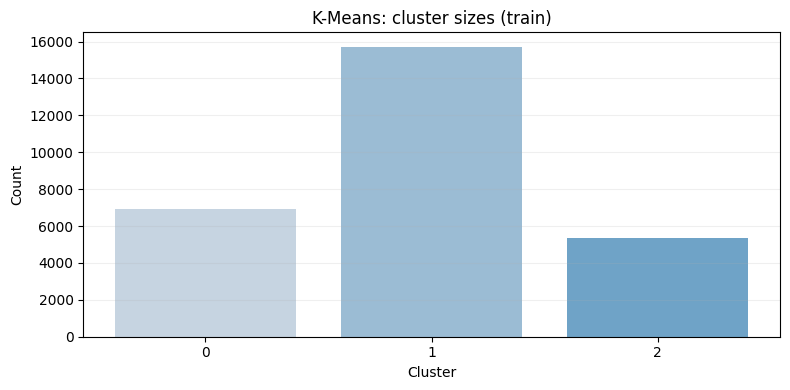

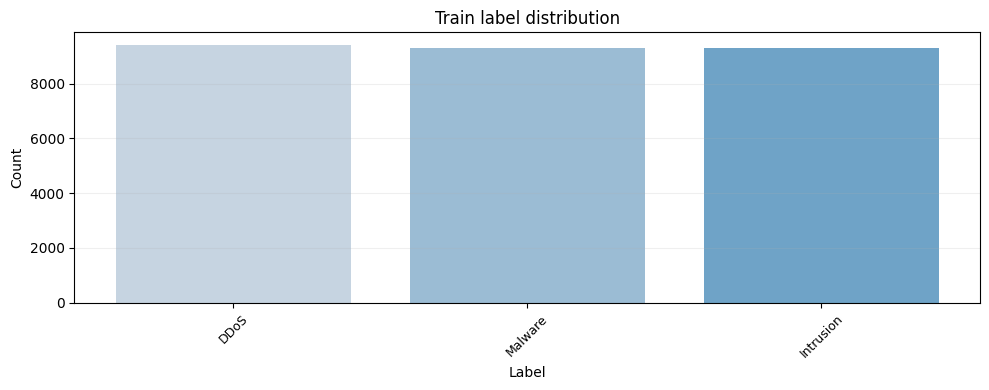

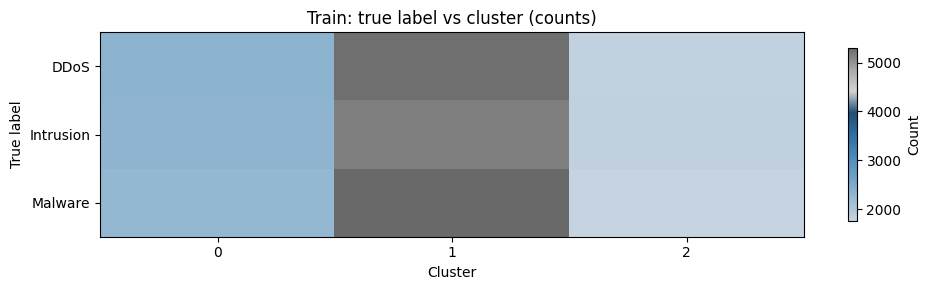

PCA explained variance ratio: PC1=0.160, PC2=0.158


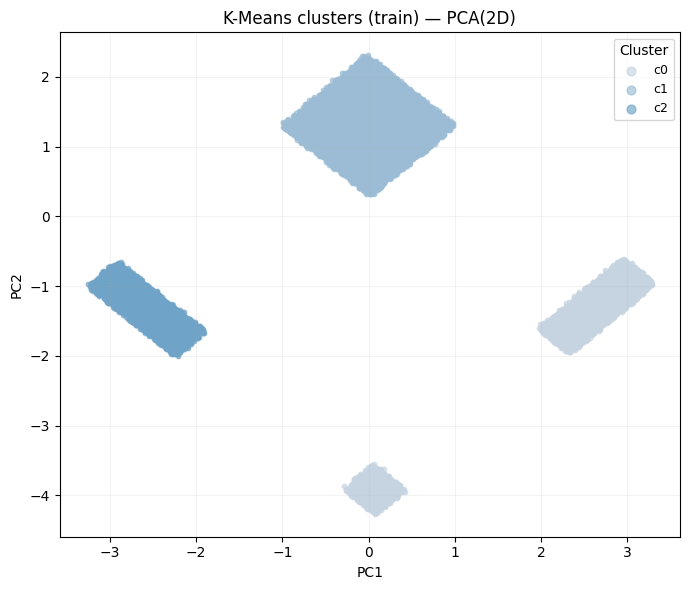

In [5]:
# Charts (uses COLOR_PALLETE from config/visualization.json)

import json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cycler import cycler
from matplotlib.colors import LinearSegmentedColormap
from sklearn.decomposition import PCA

VIZ_CONFIG_JSON = REPO_ROOT / "config" / "visualization.json"

with VIZ_CONFIG_JSON.open("r", encoding="utf-8") as f:
    _vis_cfg = json.load(f)

_palette = _vis_cfg.get("visualization", {}).get("color_palette", [])
if not isinstance(_palette, list) or not _palette:
    raise ValueError(f"Missing/invalid visualization.color_palette in {VIZ_CONFIG_JSON}")

# User-facing canonical name used across notebooks in this repo.
COLOR_PALLETE = [str(c) for c in _palette]

# Apply the palette to Matplotlib globally (affects most plots, including pandas plots).
mpl.rcParams["axes.prop_cycle"] = cycler(color=COLOR_PALLETE)
COLOR_CMAP = LinearSegmentedColormap.from_list("color_palette", COLOR_PALLETE)

print(f"Loaded COLOR_PALLETE ({len(COLOR_PALLETE)} colors) from {VIZ_CONFIG_JSON.name}")


def _cycle_colors(n: int) -> list[str]:
    return [COLOR_PALLETE[i % len(COLOR_PALLETE)] for i in range(n)]


# 1) Cluster sizes (train)
cluster_counts = (
    pd.Series(train_labels, name="cluster").value_counts().sort_index()
)
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(
    cluster_counts.index.astype(str),
    cluster_counts.values,
    color=_cycle_colors(len(cluster_counts)),
)
ax.set_title("K-Means: cluster sizes (train)")
ax.set_xlabel("Cluster")
ax.set_ylabel("Count")
ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()


# 2) Label distribution (train) — plot top N to keep readable
TOP_N = 15
label_counts = pd.Series(y_train, name="label").value_counts()
label_counts_plot = label_counts.head(TOP_N)
fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(
    label_counts_plot.index.astype(str),
    label_counts_plot.values,
    color=_cycle_colors(len(label_counts_plot)),
)
ax.set_title(
    f"Train label distribution (top {TOP_N})" if len(label_counts) > TOP_N else "Train label distribution"
)
ax.set_xlabel("Label")
ax.set_ylabel("Count")
ax.tick_params(axis="x", rotation=45, labelsize=9)
ax.grid(axis="y", alpha=0.2)
plt.tight_layout()
plt.show()


# 3) Heatmap: true label vs cluster (counts)
ct = pd.crosstab(
    pd.Series(y_train, name="true_label"),
    pd.Series(train_labels, name="cluster"),
).sort_index(axis=1)

fig, ax = plt.subplots(figsize=(10, max(3, 0.35 * len(ct.index))))
im = ax.imshow(ct.values, aspect="auto", cmap=COLOR_CMAP)
ax.set_title("Train: true label vs cluster (counts)")
ax.set_xlabel("Cluster")
ax.set_ylabel("True label")

ax.set_xticks(np.arange(ct.shape[1]))
ax.set_xticklabels(ct.columns.astype(str), rotation=0)
ax.set_yticks(np.arange(ct.shape[0]))
ax.set_yticklabels(ct.index.astype(str))

cbar = fig.colorbar(im, ax=ax, shrink=0.85)
cbar.set_label("Count")
plt.tight_layout()
plt.show()


# 4) 2D visualization via PCA on the transformed train matrix
pca = PCA(n_components=2, random_state=SEED)
X_train_2d = pca.fit_transform(X_train_t)
unique_clusters = np.unique(train_labels)

fig, ax = plt.subplots(figsize=(7, 6))
for cluster_id in unique_clusters:
    mask = train_labels == cluster_id
    ax.scatter(
        X_train_2d[mask, 0],
        X_train_2d[mask, 1],
        s=10,
        alpha=0.65,
        color=COLOR_PALLETE[int(cluster_id) % len(COLOR_PALLETE)],
        label=f"c{cluster_id}",
    )

ax.set_title("K-Means clusters (train) — PCA(2D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.grid(alpha=0.15)

# Keep legend readable
if len(unique_clusters) <= 15:
    ax.legend(title="Cluster", markerscale=2, fontsize=9)

evr = pca.explained_variance_ratio_
print(f"PCA explained variance ratio: PC1={evr[0]:.3f}, PC2={evr[1]:.3f}")
plt.tight_layout()
plt.show()
